#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

Загрузим необходимы для работы библиотеки.

In [ ]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn.metrics import make_scorer, mean_squared_error

from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor 
import catboost as cb

In [ ]:
try:
  data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except FileNotFoundError:
  data = pd.read_csv('/content/taxi.csv', index_col=[0], parse_dates=[0])
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Датасет состоит из 2х столбцов, столбец с датами мы сделали индексами.

Проверим в хронологическом ли порядке расположены даты.

In [ ]:
data.index.is_monotonic

True

Даты расположены в хронологическом порядке. 

Изменим интервал временного ряда с 10 минутного на почасовой, для этого проведем ресемплирование данных по 1 часу. В качестве агрегированного значения ряда используем суммарное значение.

In [ ]:
data = data.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


**Выводы:**

Исходный датасет содержит 2 столбца: временную шкалу и количество заказов в указанный интервал времени. Даты на шкале расположены в хронологическом порядке. В процессе подготовки датасета изменили интервал временного ряда на часовой.

## Анализ

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [ ]:
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


Датасет содержить 4416 строк, Минимальное количество заказов за 1 час - 0, а максимальное - 462. <br/>
Среднее количество заказов 84, медиана - 78. 

Визуализируем распределение количества заказов за 1 час на гистограмме.

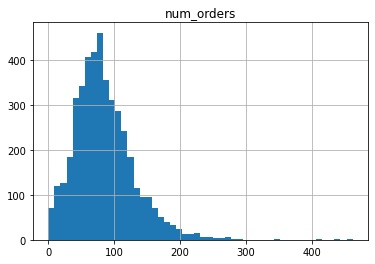

In [ ]:
data.hist(bins=50);

В основном за час приходит от 40 до 100 заказов. 

посмотрим распределение по всему временному ряду

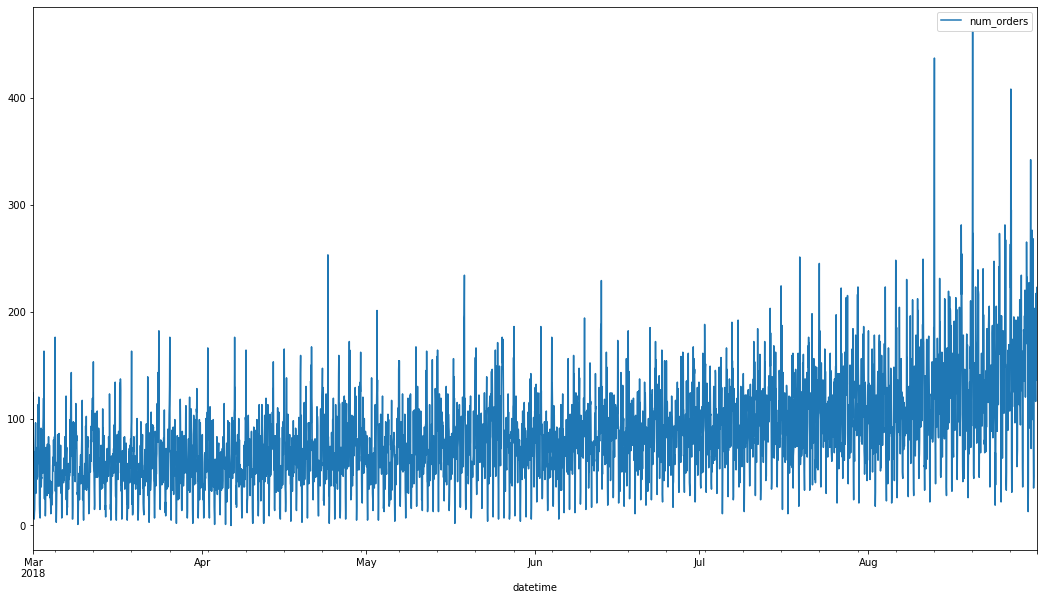

In [ ]:
data.plot(figsize=(18,10));

По графику видно, что постепенно растет количество заказов. Посмотрим распределение заказов по дням.

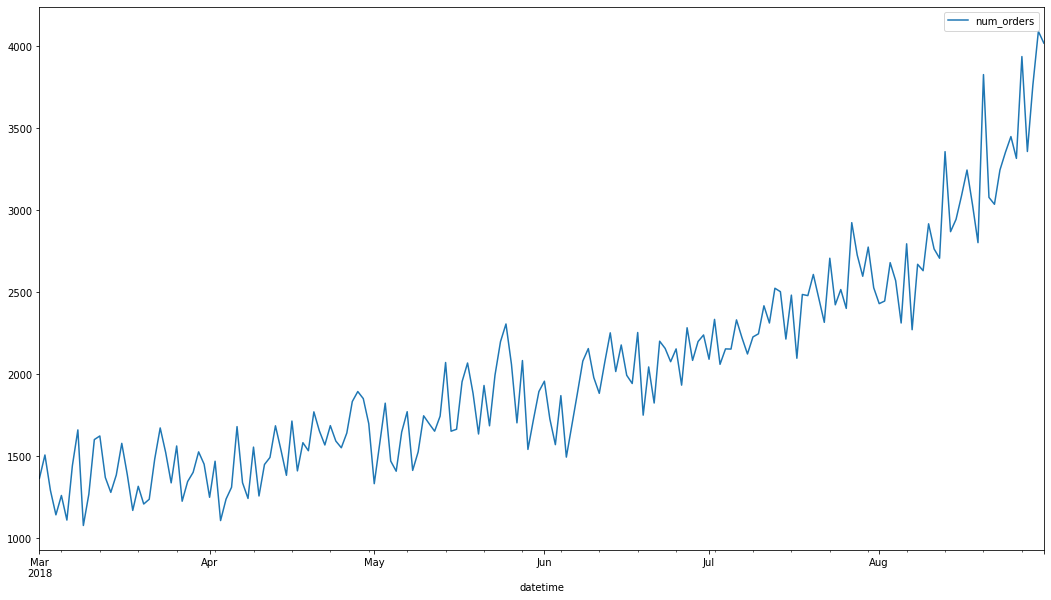

In [ ]:
data.resample('1D').sum().plot(figsize=(18,10));

Из этого графика видно, что действительно постепенно растет количество запросов в день.<br/>
Применим скользящее среднее и визуализируем результат, чтобы посмотреть действительно ли есть рост заказов.

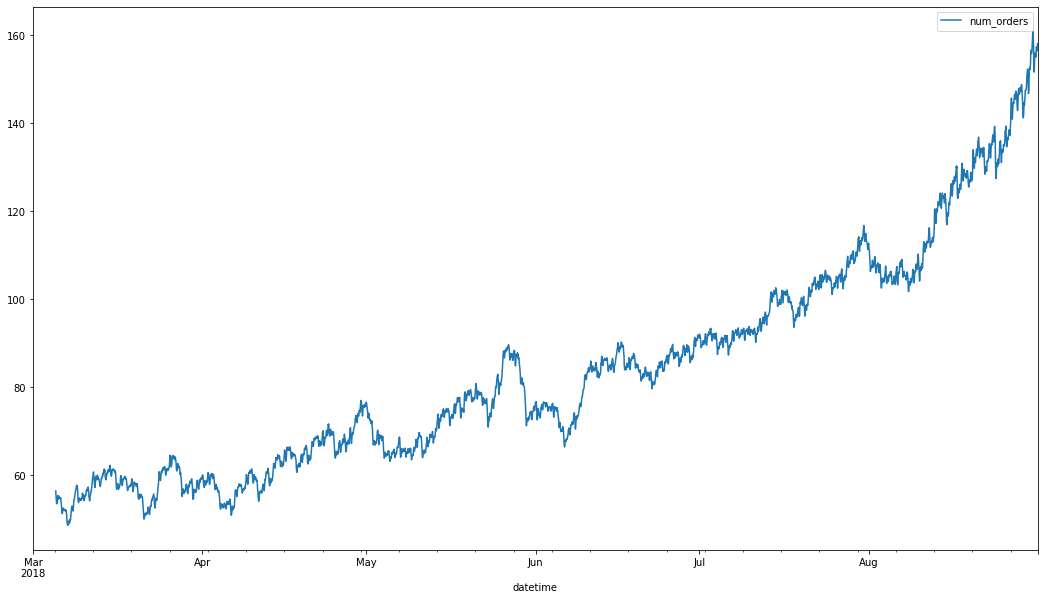

In [ ]:
data.rolling(100).mean().plot(figsize=(18, 10));

После применения скользящего среднего рост заявок стал еще более четким.

Чтобы лучше понимать временной ряд, разберём тренды и сезонность.

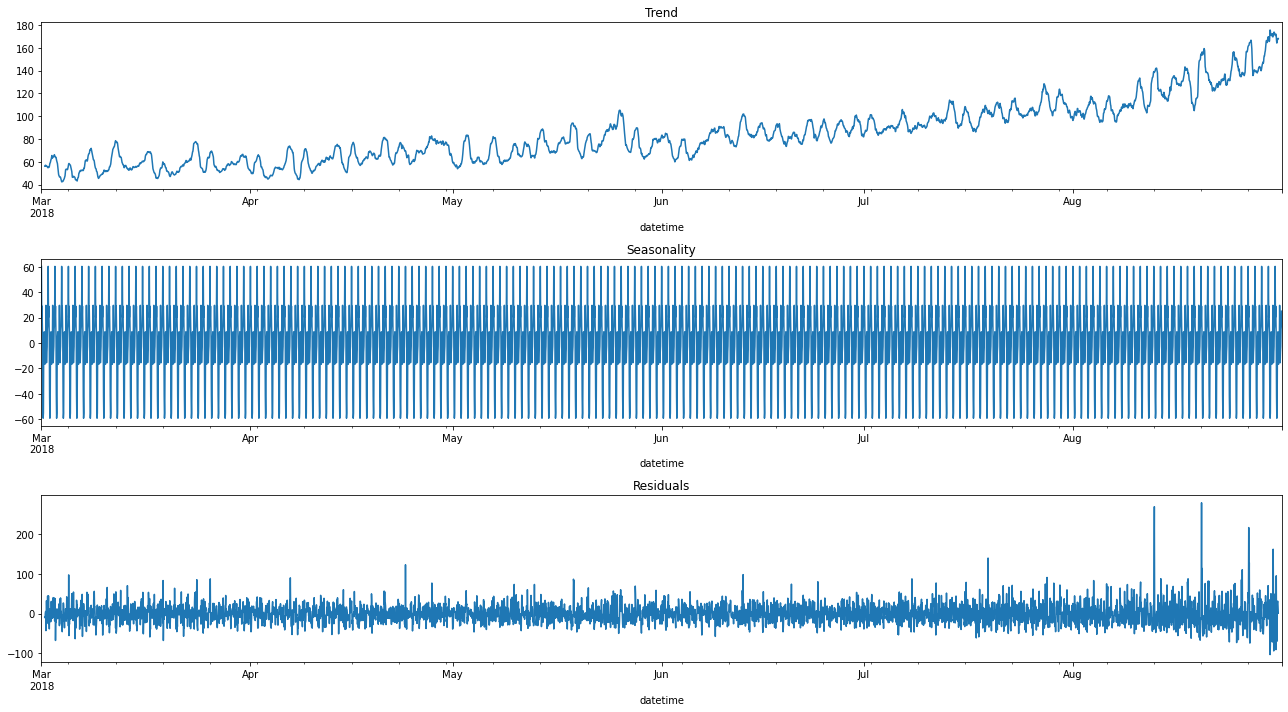

In [ ]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(18, 10))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout();

График трендов подтвердил постепенный рост заявок. <br/>
График сезонности слишком частотный, уменьшим интервал и посмотрим на распределение за пару недель.

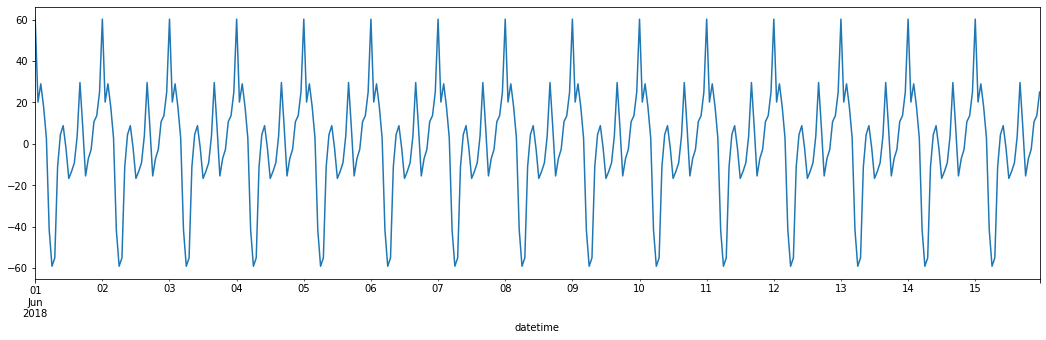

In [ ]:
decomposed = seasonal_decompose(data)
decomposed.seasonal['2018-06-01':'2018-06-15'].plot(figsize=(18, 5));

На графике сезонности явно прослеживается суточная цикличность. Утром и вечером количество заказов пиковое, а в обеденное время и ночью - минимальное.

**Вывод:**


В результате анализа датасата мы обнаружили тренд на постепенный рост количества заказов, а также увидели суточную сезонность с ростом спроса в час пик. 

## Обучение

### Подготовка данных

Качество обученных моделей будем оценивать метрикой RMSE. Напишем для этого функцию.

In [ ]:
def RMSE(target, predict):
    return (mean_squared_error(target, predict))**0.5

Напишем функцию для вычисления месяца, дня, дня недели и часа из даты. А также пропишем в этой функции создание скользящего среднего и отстающего значения. А затем применим функцию к датафрейму.

In [ ]:
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

Применим функцию с лагом до 24 часов и 100-м скользящим средним:

In [ ]:
data_copy = data.copy()
make_features(data_copy, 24, 100)
data_copy.head()

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Поскольку модель не работает с пропусками, а получить признаки для первых значений мы не можем, то удалим их.

In [ ]:
data_copy = data_copy.dropna()
data_copy.head()

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-05 04:00:00,34,3,5,0,4,51.0,32.0,176.0,86.0,68.0,...,30.0,41.0,19.0,39.0,39.0,12.0,11.0,22.0,27.0,56.46
2018-03-05 05:00:00,16,3,5,0,5,34.0,51.0,32.0,176.0,86.0,...,30.0,30.0,41.0,19.0,39.0,39.0,12.0,11.0,22.0,55.56
2018-03-05 06:00:00,3,3,5,0,6,16.0,34.0,51.0,32.0,176.0,...,56.0,30.0,30.0,41.0,19.0,39.0,39.0,12.0,11.0,54.87
2018-03-05 07:00:00,14,3,5,0,7,3.0,16.0,34.0,51.0,32.0,...,58.0,56.0,30.0,30.0,41.0,19.0,39.0,39.0,12.0,54.19
2018-03-05 08:00:00,31,3,5,0,8,14.0,3.0,16.0,34.0,51.0,...,64.0,58.0,56.0,30.0,30.0,41.0,19.0,39.0,39.0,53.67


Разделим датасет на тестовую и обучающую выборку, а также выделим признаки и целевой признак для последующего обучения моделей.

In [ ]:
train, test = train_test_split(data_copy, shuffle=False, test_size=0.1)

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

Обучим три модели (Линейную регрессию, Случайный лес и CatBoostRegressor) и выберем наилучшую.

### Линейная регрессия.

In [ ]:
model_lg = LinearRegression() # объявляем модель
model_lg.fit(features_train, target_train) # обучаем модель

predicted_lg = model_lg.predict(features_test) # предсказываем целевой признак

rmse_lg = RMSE(target_test, predicted_lg) # определим качество обученной модели
print('RMSE модели линейной регрессии:', rmse_lg)

RMSE модели линейной регрессии: 47.08306549661302


### Модель случайного леса.

Выбираем наилучшие параметры для модели.

In [ ]:
clf = RandomForestRegressor(random_state=1234)
parametrs = {
    'n_estimators': range(5, 30, 5),
    'max_depth': range(1, 15, 2),
}

grid = (GridSearchCV(clf, parametrs, scoring=make_scorer(RMSE, greater_is_better=False), 
                     cv=TimeSeriesSplit(n_splits=3).split(features_train)))
grid.fit(features_train, target_train)

grid.best_params_

{'max_depth': 9, 'n_estimators': 25}

Запускаем модель обучения с лучшими параметрами.

In [ ]:
model_forest = RandomForestRegressor(random_state=1234, max_depth=9, n_estimators=25)
model_forest.fit(features_train, target_train)

predicted_forest = model_forest.predict(features_test)

rmse_forest = RMSE(target_test, predicted_forest)
print('RMSE модели случайного леса:', rmse_forest)

RMSE модели случайного леса: 46.92449472006793


### CatBoostRegressor

Выбираем наилучшие параметры для модели.

In [ ]:
clf = cb.CatBoostRegressor(random_state=1234)
parametrs = {'depth': [4, 6, 10],
             'learning_rate': [0.03, 0.1]
            }
grid = (GridSearchCV(clf, parametrs, scoring=make_scorer(RMSE, greater_is_better=False),
                     cv=TimeSeriesSplit(n_splits=3).split(features_train)))
grid.fit(features_train, target_train, verbose=100)

grid.best_params_

0:	learn: 28.8357972	total: 50.3ms	remaining: 50.3s
100:	learn: 17.9024863	total: 222ms	remaining: 1.97s
200:	learn: 16.0620850	total: 392ms	remaining: 1.56s
300:	learn: 14.8435984	total: 570ms	remaining: 1.32s
400:	learn: 13.5484801	total: 742ms	remaining: 1.11s
500:	learn: 12.5510778	total: 927ms	remaining: 923ms
600:	learn: 11.6821964	total: 1.11s	remaining: 739ms
700:	learn: 10.9670085	total: 1.3s	remaining: 556ms
800:	learn: 10.2600035	total: 1.48s	remaining: 367ms
900:	learn: 9.6398954	total: 1.67s	remaining: 183ms
999:	learn: 9.0544984	total: 1.84s	remaining: 0us
0:	learn: 31.8935270	total: 4ms	remaining: 3.99s
100:	learn: 20.2156832	total: 238ms	remaining: 2.12s
200:	learn: 18.4548872	total: 456ms	remaining: 1.81s
300:	learn: 17.4183515	total: 661ms	remaining: 1.53s
400:	learn: 16.5695207	total: 881ms	remaining: 1.31s
500:	learn: 15.8206422	total: 1.14s	remaining: 1.14s
600:	learn: 15.1693883	total: 1.36s	remaining: 905ms
700:	learn: 14.5627767	total: 1.57s	remaining: 671ms
800

{'depth': 6, 'learning_rate': 0.03}

In [ ]:
model_cat = cb.CatBoostRegressor(random_state=1234, depth=6, learning_rate=0.03)
model_cat.fit(features_train, target_train, verbose=100)
predicted_cat = model_cat.predict(features_test)

rmse_cat = RMSE(target_test, predicted_cat)
print('RMSE модели CatBoostRegressor', rmse_cat)

0:	learn: 38.1241416	total: 6.4ms	remaining: 6.39s
100:	learn: 22.8766910	total: 708ms	remaining: 6.3s
200:	learn: 21.2565951	total: 1.38s	remaining: 5.49s
300:	learn: 19.8167517	total: 2.09s	remaining: 4.85s
400:	learn: 18.7286139	total: 2.79s	remaining: 4.17s
500:	learn: 17.6757339	total: 3.52s	remaining: 3.5s
600:	learn: 16.6620672	total: 4.3s	remaining: 2.86s
700:	learn: 15.8732870	total: 5.03s	remaining: 2.14s
800:	learn: 15.1885838	total: 5.73s	remaining: 1.42s
900:	learn: 14.5450204	total: 6.44s	remaining: 708ms
999:	learn: 13.9106399	total: 7.21s	remaining: 0us
RMSE модели CatBoostRegressor 40.824307388531466


## Тестирование

Сведем RMSE каждой модели в единую таблицу. Наилучшая модель - модель с минимальным RMSE.

In [ ]:
columns = ['Модель', 'RMSE',]
model_lineregression = ['Линейная регрессия', rmse_lg]
model_forest = ['Случайный лес', rmse_forest]
model_cat = ['CatBoostRegressor', rmse_cat]

table = pd.DataFrame([model_lineregression, model_forest, model_cat], columns = columns)
display(table)

,Модель,RMSE
0,Линейная регрессия,47.083065
1,Случайный лес,46.924495
2,CatBoostRegressor,40.824307


Модель CatBoostRegressor показала наилучшие результаты. Ее RMSE - 40.82

**Вывод:**

Целью данной работы было построение модели прогнозирования количества заказов такси на следующий час.

В процессе работы была проведена подготовка и анализ данных для будущего обучения модели. При анализе данных была обнаружен тренд на постепенное увеличение количества заказов такси, а также обнаружена явная суточная сезонность с повышенным спросом в час пик. 

В процессе выбора наилучшей модели обучения проверили 3 модели (Линейная регрессия, Случайный лес, CatBoostRegressor).

Наилучшие результаты на показала модель CatBoostRegressor c RMSE = 40,82.